#### TODO: 

#### Normalise by 


#### Other motif residues 
- create 2nd and 3rd place combinations
to get a better idea of the motif.  


i.e. 
get "top 3" closest apart from sequence-adjacent residues, considering
a. RRA the same as RAR and ARR 
b. RR- (if only 2 within bubble)

Also, 

#### Weighted score
- somehow 'weight' the distance to the contribution 
- i.e. sometimes the 3rd closest residue will be very close; othertimes it will be just on the edge of the bubble and we need to account for this


NOTE: this is likely not to matter too much (or vary a lot) since we are already controlling for distance by enforcing the bubble radius in the first place. 

What is likely to vary, however, is if we weight by RSA (i.e. higher surface accessibility contributions should matter more) as the residue is likely more visible and important to the kinase. 





## Visualising motifs

In [7]:
# Autoreload 
%load_ext autoreload
%autoreload 2

from pathlib import Path 
import pandas as pd 
import numpy as np
import os 
import re 
import gzip 
import shutil
import Bio.PDB.MMCIF2Dict
from typing import Union, List, Tuple, Dict, Optional
from pathlib import Path

pd.options.mode.chained_assignment = None  # default='warn'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from phosphosite.utils import aa1to3, aa3to1
from phosphosite.utils.graphs import get_seq_distance

radius = 6.0

In [183]:
# LOAD DATAFRAMES
# For each file that ends with .csv, load it into a dataframe.
if False:
    radius = 6.0
    motif_dfs = []
    for f in Path("data/processed/motifs").glob(f"*-R{radius}Å.csv"):
        try:
            df = pd.read_csv(
                f, 
                header=0,
                delimiter="\t",
            )
        except pd.errors.EmptyDataError:
            continue
        motif_dfs.append(df)
    
    motif_df = pd.concat(motif_dfs)
    total_motif_df = pd.concat(motif_dfs)
    total_motif_df.to_csv("data/motif_dataframe/all_R6A.csv", index=False)

In [9]:
motif_df = pd.read_csv(
    "data/motif_dataframe/all_R6A.csv",
    header=0,
    delimiter=",",
)
motif_df

,uniprot_id,prev,site,next,nearest_node
0,A0A0B4J2A2,A:LYS:118,A:THR:119,A:GLU:120,A:HIS:92
1,A0A0B4J2A2,A:GLY:109,A:SER:110,A:GLN:111,A:LYS:76
2,A0A0B4J2A2,A:LEU:98,A:SER:99,A:MET:100,A:ALA:128
3,A0A0B4J2A2,A:GLY:94,A:SER:95,A:GLY:96,A:THR:116
4,A0A0B4J2A2,A:ILE:78,A:TYR:79,A:GLY:80,A:SER:77
...,...,...,...,...,...
218935,Q96GZ6,A:GLN:274,A:SER:275,A:PRO:276,A:ILE:278
218936,Q96GZ6,A:SER:27,A:THR:28,A:GLY:29,NaN
218937,Q96GZ6,A:LEU:26,A:SER:27,A:THR:28,NaN
218938,Q96GZ6,A:VAL:48,A:THR:49,A:PRO:50,A:SER:47


In [193]:
motif_df["site_res"] = motif_df.apply(
    lambda row: row["site"].split(":")[1], 
    axis=1,
)
nearest_node = motif_df[~motif_df["nearest_node"].isna()]
percentage = len(nearest_node) / len(motif_df) * 100
print(f"{percentage:.1f}% of motifs have a nearest node. ({len(nearest_node)} / {len(motif_df)})")

57.9% of motifs have a nearest node. (126760 / 218940)


In [94]:
list(nearest_node["uniprot_id"].unique())[0:2]

['A0A0B4J2A2', 'Q8IVU1']

In [194]:
nearest_node["sequence_distance"] = nearest_node.apply(
    lambda row: get_seq_distance(row["site"], row["nearest_node"], absolute=False),
    axis=1,
)
# min and max sequence distance
print(nearest_node["sequence_distance"].min())
print(nearest_node["sequence_distance"].max())
nearest_node[0:2]

-2409
2381


,uniprot_id,prev,site,next,nearest_node,site_res,sequence_distance
0,A0A0B4J2A2,A:LYS:118,A:THR:119,A:GLU:120,A:HIS:92,THR,27
1,A0A0B4J2A2,A:GLY:109,A:SER:110,A:GLN:111,A:LYS:76,SER,34


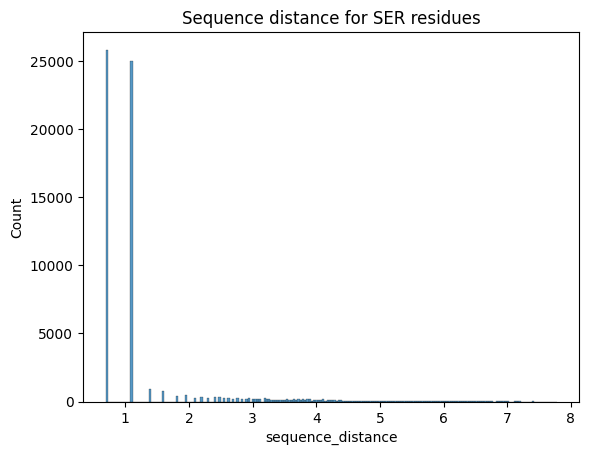

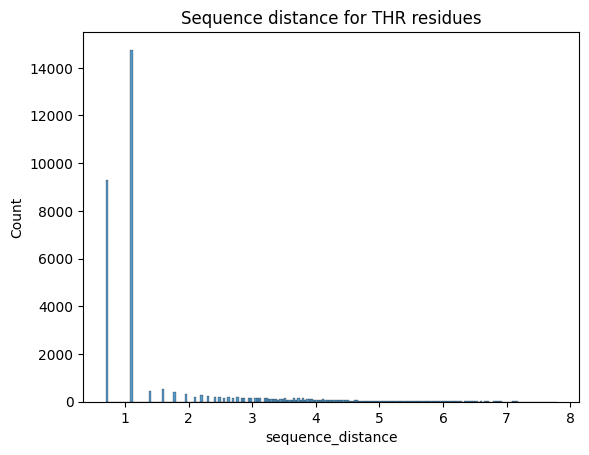

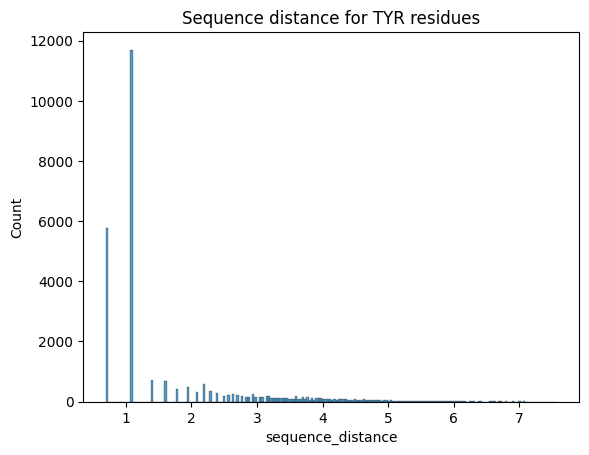

In [195]:
# plot histogram of sequence distances
import matplotlib.pyplot as plt
import seaborn as sns

absolute_val = True
for aa in ["SER", "THR", "TYR"]:
    df = nearest_node[nearest_node["site_res"] == aa]
    if absolute_val:
        df["sequence_distance"] = df["sequence_distance"].abs()

    # log
    df["sequence_distance"] = np.log(df["sequence_distance"])
    # plot histogram of sequence distances per residue 
    plt.figure()
    sns.histplot(
        data=df,
        x="sequence_distance",
        bins=200,
    )
    plt.title(f"Sequence distance for {aa} residues")
    plt.show()


### Get background AA frequencies.

In [260]:
from phosphosite.utils.compseq import get_background_df
background_df = get_background_df()
# Remove U 
background_df = background_df.drop("U", axis=1)
# Drop "Other" 
background_df = background_df.drop("Other", axis=1)

# Change background df to 3letter column names.
background_df.columns = [aa1to3[aa] for aa in background_df.columns]
background_df.loc["freq", "ALA"]

0.0701144

In [177]:
def filter_df_residue(
    df: pd.DataFrame,
    residue: str,
    
) -> pd.DataFrame:
    """Filter dataframe to only include rows with the specified residue.
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to filter.
    residue : str
        The residue to filter by. Can be either a one letter or three letter amino acid code.
    
    """
    if len(residue) == 1: 
        residue = aa1to3[residue]
    elif len(residue) != 3:
        raise ValueError("Residue must be a three letter amino acid code.")
    residue = residue.upper()
    df = df[df["site_res"] == residue]
    df["prev"] = df["prev"].apply(lambda x: x.split(":")[1])

    def func(x):
        if isinstance(x, float):
            return np.nan
        return x.split(":")[1]
    df["next"] = df["next"].apply(lambda x: func(x))
    return df

In [178]:
serine      = filter_df_residue(nearest_node, "S")
threonine   = filter_df_residue(nearest_node, "thr")
tyrosine    = filter_df_residue(nearest_node, "Tyr")
len(serine), len(threonine), len(tyrosine)

(64551, 33350, 28859)

In [179]:
serine[0:2]

,uniprot_id,prev,site,next,nearest_node,site_res,sequence_distance
1,A0A0B4J2A2,GLY,A:SER:110,GLN,A:LYS:76,SER,34
2,A0A0B4J2A2,LEU,A:SER:99,MET,A:ALA:128,SER,-29


In [107]:
# Group by every combination of prev and next; 
# Count the number of times each combination occurs.
serine.groupby(["prev", "next"]).size().reset_index(name="count")[0:2]

,prev,next,count
0,ALA,ALA,329
1,ALA,ARG,251


In [109]:
serine["nearest_res"] = serine["nearest_node"].apply(lambda x: x.split(":")[1])
# For each combination of (prev, next); count the number of times each nearest_res occurs. 
motif_counts = serine.groupby(["prev", "next", "nearest_res"]).size().reset_index(name="count")
# Collapse to one row per combination of (prev, next), and a column for each nearest_res.  
motif_counts = motif_counts.pivot_table(
    index=["prev", "next"],
    columns="nearest_res",
    values="count",
    fill_value=0,
).reset_index()
motif_counts[0:2]

nearest_res,prev,next,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,...,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
0,ALA,ALA,45,33,10,14,4,22,34,14,...,31,21,10,8,8,23,15,5,6,7
1,ALA,ARG,30,23,5,14,10,14,17,24,...,20,15,6,9,6,19,9,0,7,6


In [110]:
# Make the prev and next columns into a single column and use as the index.
motif_counts["motif"] = motif_counts.apply(
    lambda row: f"{row['prev']}-{row['next']}",
    axis=1,
)
motif_counts = motif_counts.set_index("motif")

# Drop the prev and next columns.
motif_counts = motif_counts.drop(columns=["prev", "next"])
motif_counts[0:2]

nearest_res,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
motif,,,,,,,,,,,,,,,,,,,,
ALA-ALA,45,33,10,14,4,22,34,14,9,10,31,21,10,8,8,23,15,5,6,7
ALA-ARG,30,23,5,14,10,14,17,24,5,12,20,15,6,9,6,19,9,0,7,6


In [111]:
# Group by every combination of prev and next; 
# Count the number of times each combination occurs.
count_df = serine.groupby(["prev", "next"]).size().reset_index(name="count")

# Turn into a 2d matrix where each row is a prev and each column is a next.
count_df = count_df.pivot_table(
    index="prev",
    columns="next",
    values="count",
    fill_value=0,
)
count_df[0:2]

next,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
prev,,,,,,,,,,,,,,,,,,,,
ALA,329,251,119,200,63,286,296,290,67,169,608,234,94,199,516,291,153,46,87,277
ARG,243,300,121,160,62,216,193,219,86,220,631,147,116,194,454,328,145,50,80,251


In [112]:
def make_count_df(
    df: pd.DataFrame,
):
    count_df = df.groupby(["prev", "next"]).size().reset_index(name="count")
    # Turn into a 2d matrix where each row is a prev and each column is a next.
    count_df = count_df.pivot_table(
        index="prev",
        columns="next",
        values="count",
        fill_value=0,
    )
    return count_df

def make_motif_df(
    df: pd.DataFrame
) -> pd.DataFrame:
    df["nearest_res"] = df["nearest_node"].apply(lambda x: x.split(":")[1])
    # For each combination of (prev, next); count the number of times each nearest_res occurs. 
    motif_counts = df.groupby(["prev", "next", "nearest_res"]).size().reset_index(name="count")
    # Collapse to one row per combination of (prev, next), and a column for each nearest_res.  
    motif_counts = motif_counts.pivot_table(
        index=["prev", "next"],
        columns="nearest_res",
        values="count",
        fill_value=0,
    ).reset_index()
    motif_counts
    # Make the prev and next columns into a single column and use as the index.
    motif_counts["motif"] = motif_counts.apply(
        lambda row: f"{row['prev']}-{row['next']}",
        axis=1,
    )
    motif_counts = motif_counts.set_index("motif")

    # Drop the prev and next columns.
    motif_counts = motif_counts.drop(columns=["prev", "next"])
    return motif_counts

In [5]:
from phosphosite.motif.visualisation import plot_heatmap

In [114]:
plot = False

In [115]:
if plot:
    dff = motif_counts.div(motif_counts.sum().sum())
    plot_heatmap(dff, aspect="auto")

    dff = motif_counts.div(motif_counts.sum(axis=1), axis=0)
    plot_heatmap(dff, aspect="auto")

In [117]:
def get_top_hit_df(motif_df: pd.DataFrame) -> pd.DataFrame:
    """Return a dataframe with the top hit for each motif."""
    # New column "res" which stores the column name of the largest value in each row.
    df = pd.DataFrame()
    df.index = motif_df.index
    df["res"] = motif_df.idxmax(axis=1)
    
    # New column "count" which stores the largest value in each row.
    df["count"] = motif_df.max(axis=1)
    return df

def make_adjacency_matrix(
    motif_df: pd.DataFrame,
    column: str = "count",
) -> pd.DataFrame:
    """Turn df into an adjacency matrix.
    
    Assumes index is of form "A-B"
    """
    # Split the index into prev and next columns.
    motif_df["prev"] = motif_df.index.str.split("-").str[0]
    motif_df["next"] = motif_df.index.str.split("-").str[1]
    # Turn into a 2d matrix where each row is a prev and each column is a next.


    # Check if column is numeric. 
    if motif_df[column].dtype == "object":

        #raise ValueError(f"Column {column} is not numeric.")
        
        # Make a dictionary of the unique values in the column.
        unique_values = motif_df[column].unique()
        value_dict = {value: i for i, value in enumerate(unique_values)}
        # Replace the values in the column with the index of the value in the dictionary.
        motif_df[column] = motif_df[column].apply(lambda x: value_dict[x])
        df = motif_df.pivot_table(
            index="prev",
            columns="next",
            values=column,
            fill_value=0,
        )
        
        # Convert back to the original values.
        df = df.applymap(lambda x: unique_values[x])
        return df
    else:
        df = motif_df.pivot_table(
            index="prev",
            columns="next",
            values=column,
            fill_value=0,
        )
        return df


### Plot normalised heatmaps.

In [121]:
df = filter_df_residue(nearest_node, "SER")
count_df = make_count_df(df)
count_df
# Normalise to frequencies.
count_df = count_df.div(count_df.sum().sum())
count_df[0:2]

next,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
prev,,,,,,,,,,,,,,,,,,,,
ALA,0.005105,0.003895,0.001847,0.003103,0.000978,0.004438,0.004593,0.004500,0.001040,0.002622,0.009435,0.003631,0.001459,0.003088,0.008007,0.004516,0.002374,0.000714,0.001350,0.004298
ARG,0.003771,0.004655,0.001878,0.002483,0.000962,0.003352,0.002995,0.003398,0.001334,0.003414,0.009791,0.002281,0.001800,0.003010,0.007045,0.005090,0.002250,0.000776,0.001241,0.003895


In [124]:
from phosphosite.utils.compseq import parse_compseq_output
df = parse_compseq_output()
df.loc["freq", "ASA"]

0.0004622

In [126]:
from phosphosite.utils.normalisation import get_frequency_matrix
freq_df = parse_compseq_output()
# Pairs like 'ASA'
serine_triplet_freq = get_frequency_matrix(freq_df, centre_residue="S", metric="freq", letter_code=1)
serine_triplet_freq.sum().sum()

0.0834777

In [131]:
# Pairs like 'AXA' 
x_triplet_freq = get_frequency_matrix(freq_df, centre_residue="X", metric="freq", letter_code=1)
x_triplet_freq.sum().sum()

0.999989

In [132]:
serine_triplet_freq = get_frequency_matrix(freq_df, centre_residue="S", metric="count", letter_code=3)
# Normalise to sum to 1. 
serine_triplet_freq = serine_triplet_freq.div(serine_triplet_freq.sum().sum())
serine_triplet_freq.sum().sum()

1.0000000000000002

In [83]:
# show these lists side by side: list(serine_triplet_freq.columns), list(count_df.columns)

for i in range(len(serine_triplet_freq.columns)):
    print(serine_triplet_freq.columns[i], count_df.columns[i])

ALA ALA
ARG ARG
ASN ASN
ASP ASP
CYS CYS
GLN GLN
GLU GLU
GLY GLY
HIS HIS
ILE ILE
LEU LEU
LYS LYS
MET MET
PHE PHE
PRO PRO
SER SER
THR THR
TRP TRP
TYR TYR
VAL VAL


### Raw counts.

In [265]:
plots = Path("./plots")

In [261]:
df = filter_df_residue(nearest_node, "SER")
count_df = make_count_df(df)
ordering = count_df.mean(axis=0).sort_values(ascending=False).index
count_df = count_df[ordering] 
count_df = count_df.reindex(ordering, axis=0)
count_df.index.name = "prev"


In [275]:
for site in ["SER", "THR", "TYR"]:
    df = filter_df_residue(nearest_node, site)
    count_df = make_count_df(df)
    motif_df = make_motif_df(df)

    # order count_df columns (and index) by average value
    # get average value across columns 
    ordering = count_df.mean(axis=0).sort_values(ascending=False).index
    count_df = count_df[ordering]
    count_df = count_df.reindex(ordering)
    count_df.index.name = "prev" # rename index 

    filepath = plots / f"{site}_sequence_pairs_COUNT.png"
    plot_heatmap(count_df, title=f"{site} phosphosites: counts of sequence-adjacent residue pairs", aspect=None, filepath=filepath)

    # 

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


### Normalise by *Residue-specific* triplet background frequency (e.g. ASA)

In [168]:
for site in ["SER", "THR", "TYR"]:
    df = filter_df_residue(nearest_node, site)
    count_df = make_count_df(df)
    motif_df = make_motif_df(df)

    count_df = count_df.div(count_df.sum().sum()) # Turn counts into frequencies 

    # GET NORMALISATION DATAFRAME
    residue_triplet_freq = get_frequency_matrix(freq_df, centre_residue=aa3to1[site], metric="count", letter_code=3)
    # Normalise to sum to 1. 
    residue_triplet_freq = residue_triplet_freq.div(residue_triplet_freq.sum().sum())

    # Divide count_df by triplet_freq to get "normalised frequency in ASA (or ATA or AYA) triplets"
    count_df = count_df.div(residue_triplet_freq) 

    # ORDER BY MEAN 
    # order count_df columns (and index) by average value
    # get average value across columns 
    ordering = count_df.mean(axis=0).sort_values(ascending=False).index
    count_df = count_df[ordering]
    count_df = count_df.reindex(ordering)
    count_df.index.name = "prev" # rename index 
    
    plot_heatmap(count_df, title=f"{site} phosphosites: frequency of triplets (normalised to {site} triplet background) (R={radius}Å)", aspect=None)

    

### Normalise to *generic* triplet background (e.g. AXA)

In [169]:
# CENTRE RESIDUE SHOULD BE 'X'. 
centre_residue = "X"
metric = "freq"

for site in ["SER", "THR", "TYR"]:
    df = filter_df_residue(nearest_node, site)
    count_df = make_count_df(df)
    motif_df = make_motif_df(df)

    count_df = count_df.div(count_df.sum().sum())

    residue_triplet_freq = get_frequency_matrix(freq_df, centre_residue=centre_residue, metric=metric, letter_code=3)
    # Normalise to sum to 1. 
    residue_triplet_freq = residue_triplet_freq.div(residue_triplet_freq.sum().sum())

    # Divide count_df by triplet_freq to get "normalised frequency in ASA (or ATA or AYA) triplets"
    count_df = count_df.div(residue_triplet_freq)

    # ORDER BY MEAN
    # order count_df columns (and index) by average value
    # get average value across columns 
    ordering = count_df.mean(axis=0).sort_values(ascending=False).index
    count_df = count_df[ordering]
    count_df = count_df.reindex(ordering)
    count_df.index.name = "prev" # rename index 
    
    plot_heatmap(count_df, title=f"{site} phosphosites: frequency of triplets (normalised to {centre_residue} triplet background) (R={radius}Å)", aspect=None)

### Plot 3rd character frequency per "seq adjacency pair"

In [231]:
background_df.loc["freq", "A"]

0.0701144

In [235]:
background_df["A"]

observations
count       799500.000000
freq             0.070114
exp              0.070114
freq/exp         1.000000
Name: A, dtype: float64

In [221]:
df = filter_df_residue(nearest_node, "SER")
motif_df = make_motif_df(df)
motif_df = motif_df.div(motif_df.sum(axis=1), axis=0)
motif_df.sum(axis=1)

motif
ALA-ALA    1.0
ALA-ARG    1.0
ALA-ASN    1.0
ALA-ASP    1.0
ALA-CYS    1.0
          ... 
VAL-SER    1.0
VAL-THR    1.0
VAL-TRP    1.0
VAL-TYR    1.0
VAL-VAL    1.0
Length: 400, dtype: float64

In [257]:
new_df = background_df[motif_df.columns]
motif_df.div(new_df.loc["freq", motif_df.columns], axis=1)

nearest_res,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
motif,,,,,,,,,,,,,,,,,,,,
ALA-ALA,1.860314,1.079318,0.727930,1.101875,0.377730,1.094371,0.734113,1.189843,1.657154,1.003598,0.959689,0.455236,0.815681,0.714682,0.275393,1.564743,0.649973,0.000000,1.306772,1.166951
ALA-ARG,1.296582,0.644788,0.253672,1.535948,0.789800,0.572058,1.023309,0.276428,0.346496,2.518118,1.368151,1.110501,1.705515,0.747167,0.719778,0.545289,0.509638,2.994543,3.415427,0.457498
ALA-ASN,0.713120,1.477638,1.860264,1.055964,0.723983,0.699181,0.469017,0.506785,0.635242,0.384712,1.504966,0.872536,3.126778,0.456602,0.791756,0.799758,1.245782,0.000000,1.878485,1.397910
ALA-ASP,1.351175,1.306543,1.762356,0.444616,0.914505,0.662382,0.888663,0.800187,0.401206,0.971905,1.689787,0.734767,1.974807,1.153521,0.833427,0.252555,0.196702,6.067890,1.581882,0.529734
ALA-CYS,1.296582,1.074646,0.000000,1.279956,6.581663,1.271239,0.426379,0.460714,1.154986,1.398954,0.608067,1.057620,1.421263,0.000000,0.959704,0.727052,1.698794,2.495453,0.000000,0.508331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VAL-SER,1.052929,1.547058,1.123650,1.700882,1.166147,0.281550,0.566597,0.612224,0.511605,1.239342,0.808036,1.873904,0.944329,0.919333,0.956483,0.644100,0.752486,1.658052,1.512873,1.238417
VAL-THR,1.129695,0.877805,0.828831,0.418204,0.430089,0.415355,0.835871,0.903181,0.377372,1.828336,1.291390,1.555015,0.464373,0.542498,1.254266,0.831431,1.110103,0.000000,2.231863,1.162618
VAL-TRP,1.188534,0.000000,0.000000,0.000000,0.000000,0.000000,3.517624,2.533925,0.000000,0.000000,0.836092,0.000000,0.000000,2.283011,0.000000,1.999394,1.557228,0.000000,0.000000,1.397910


In [236]:

def apply_normalisations(
    df: pd.DataFrame,
    normalisations: List[str],
) -> pd.DataFrame: 
    """Apply normalisations to a dataframe of counts in order.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe of counts.
    normalisations : List[str]
        List of normalisations to apply to the dataframe.
    """
    for normalisation in normalisations:
        if normalisation == "freq":
            df = df.div(df.sum().sum()) # everything sums to 1
        elif normalisation == "row":
            df = df.div(df.sum(axis=1), axis=0) # each row sums to 1
        elif normalisation == "background":
            # Assume that each column is an amino acid.  
            # For each row in df, divide that row by the background_df 'freq' row.
            # This will normalise each row by the frequency of the residues. 
            
            # Change ordering of background df to fit df 
            background_df = background_df[df.columns]
            df = df.div(background_df.loc["freq", :]) 
             
            
        
        else:
            raise ValueError(f"Normalisation {normalisation} not recognised.")
    
    return df

In [277]:
placement = "vertical"

normalisation = None
for site in ["SER", "THR", "TYR"]:
    df = filter_df_residue(nearest_node, site)
    motif_df = make_motif_df(df)


    if placement == "horizontal":
        motif_df = motif_df.T
        aspect = "auto"
        height = 1000
    else: 
        aspect = "auto" 
        height = 8000

    
    filepath = plots / f"{site}_3rd_nearest_counts.html"
    plot_heatmap(
        motif_df, 
        title=f"{site} phosphosites: frequency of spatially-nearest residue for sequence-adjacent pairs (R={radius}Å) normalisation={normalisation}", 
        aspect=aspect, 
        height=height,
        filepath=filepath,
    )

In [264]:
placement = "vertical"
#placement = "horizontal"


normalisation = None
normalisation = ["row", "background"]
#normalisation = ["freq", "background"]
for site in ["SER", "THR", "TYR"]:
    df = filter_df_residue(nearest_node, site)
    motif_df = make_motif_df(df)

    if normalisation is None:
        pass
    
    elif isinstance(normalisation, list):
        motif_df = apply_normalisations(motif_df, normalisation)

    if placement == "horizontal":
        motif_df = motif_df.T
        aspect = "auto"
        height = 1000
    else: 
        aspect = "auto" 
        height = 8000

    

    plot_heatmap(motif_df, 
    title=f"{site} phosphosites: frequency of spatially-nearest residue for sequence-adjacent pairs (R={radius}Å) normalisation={normalisation}", 
    aspect=aspect, 
    height=height,
    filepath=filepath,
    )

    